![Banner](https://i.imgur.com/a3uAqnb.png)

# Double DQN Implementation - Homework Assignment

In this homework, you will implement **Double Deep Q-Learning** using PyTorch to train an agent to play the Lunar Lander game. This will involve understanding reinforcement learning concepts, implementing experience replay, and optimizing the training process.

## 📌 Project Overview
- **Task**: Train an RL agent to land a spacecraft safely
- **Algorithm**: Double Deep Q-Network (DDQN)
- **Environment**: LunarLander-v2 from OpenAI Gym
- **Goal**: Achieve consistent successful landings (score > 200)

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand Q-Learning and temporal difference methods
- Implement experience replay for stable training
- Use target networks to reduce correlation
- Apply Double DQN to reduce maximization bias
- Evaluate reinforcement learning agents
- Visualize training progress and agent behavior# Double DQN

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the LunarLander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![LunarLander](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails separate action selection and action evaluation in the target value.

- Use the current network to select the max action for the next state
and then use the target network to get the target Q-value for that
action.




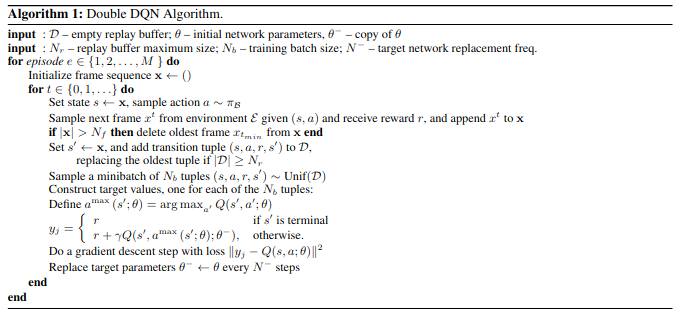

[Image Source](https://leejungi.github.io/posts/Dueling-DQN/)

In [ ]:
# TODO: Install required packages (uncomment if needed):
# !pip install -q swig
# !pip install -q gym[box2d]
# !pip install -q pygame
# !pip install -q moviepy

# TODO: Import all necessary libraries:
#       - gym for the environment
#       - torch, torch.nn, torch.optim for neural networks
#       - math, random, numpy for utilities
#       - matplotlib for plotting
#       - collections.namedtuple for experience storage
#       - itertools.count for infinite counting
#       - PIL.Image for image processing
#       - torchvision.transforms for image transforms

# TODO: Set random seeds for reproducibility
# TODO: Check if GPU is available and set device

Using device: cuda


## 1️⃣ Environment Setup

**Task**: Create and explore the Lunar Lander environment.

**Requirements**:
- Initialize the LunarLander-v2 environment
- Understand the state space (8-dimensional vector)
- Understand the action space (4 discrete actions)
- Explore the reward structure

In [ ]:
# TODO: Create the Lunar Lander environment
#       - Use gym.make("LunarLander-v2")
#       - Print environment information

# TODO: Print environment details:
#       - Action space size
#       - Observation space shape
#       - Reset environment and print initial state

# TODO: Reset environment and examine initial state

# TODO: Explore one random step

Action space: Discrete(4)
Action space size: 4
Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Observation space shape: (8,)
Initial state shape: (8,)
Sample state: [-0.00717402  1.4180919  -0.72666776  0.31872848  0.00831973  0.16460125
  0.          0.        ]
After random action 0:
Next state: [-0.0143486   1.4246864  -0.72568494  0.2930202   0.01645343  0.16268922
  0.          0.        ]
Reward: -0.38982858400285636
Terminated: False


/home/ali/.virtualenvs/PythonProject/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## 2️⃣ Experience Replay Memory

**Task**: Implement experience replay to store and sample transitions.

**Requirements**:
- Create a namedtuple for storing transitions (state, action, next_state, reward)
- Implement a circular buffer with fixed capacity
- Add methods for storing and sampling experiences
- Ensure random sampling to break correlation between consecutive experiences

Learning from batches of consecutive samples is problematic as the sample are correlated and it can create a bad feedback loop if one action is dominated in the samples.

We can address these problems using an experience replay memory. It maintains a record for all the transitions experienced. The agent is then trained by sampling random minibatches from the replay memory.

In [ ]:
# TODO: Define Transition namedtuple with fields:
#       - state: current state
#       - action: action taken
#       - next_state: resulting state (None if terminal)
#       - reward: immediate reward received

# TODO: Implement ReplayMemory class:
class ReplayMemory(object):
   def __init__(self, capacity):
       # TODO: Initialize memory buffer and position counter
       #       - self.capacity: maximum number of experiences to store
       #       - self.memory: list to store transitions
       #       - self.position: current position in circular buffer

   def push(self, *args):
       """Saves a transition."""
       # TODO: Add transition to memory:
       #       - If memory not full, append None
       #       - Store transition at current position
       #       - Update position with wrap-around

   def sample(self, batch_size):
       # TODO: Return random sample of transitions
       #       - Use random.sample() to get batch_size transitions

   def __len__(self):
       # TODO: Return current size of memory

# TODO: Test the replay memory implementation

Testing ReplayMemory...
Initial memory size: 0
Memory size after 5 pushes: 5


## 3️⃣ Deep Q-Network Architecture

**Task**: Design the neural network that will approximate the Q-function.

**Requirements**:
- Create a feedforward neural network with appropriate layers
- Input: 8-dimensional state vector (LunarLander observations)
- Output: 4-dimensional vector (Q-values for each action)
- Use ReLU activations and appropriate layer sizes

In [ ]:
# TODO: Implement DQN class inheriting from nn.Module:
class DQN(nn.Module):
   def __init__(self, n_observations, n_actions):
       # TODO: Initialize the network layers:
       #       - layer1: Linear(n_observations, 128) 
       #       - layer2: Linear(128, 128)
       #       - layer3: Linear(128, n_actions)
       # add more if you need it(You don't)

   def forward(self, x):
       # TODO: Implement forward pass:
       #       - Apply ReLU activation to first two layers
       #       - No activation on final layer (raw Q-values)

# TODO: Test the network architecture

Network input size: 8
Network output size: 4
Test input shape: torch.Size([1, 8])
Test output shape: torch.Size([1, 4])
Sample Q-values: tensor([[ 0.0553, -0.0330,  0.0814, -0.0789]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


## 4️⃣ Exploration Strategy

**Task**: Implement epsilon-greedy exploration strategy.

**Requirements**:
- Start with high exploration (epsilon = 0.9)
- Gradually decay to low exploration (epsilon = 0.05)
- Use exponential decay schedule
- Balance exploration vs exploitation during training

In [ ]:
# TODO: Implement epsilon-greedy action selection function:
def select_action(state, policy_net, steps_done, eps_start=0.9, eps_end=0.05, eps_decay=1000):
   """
   Select action using epsilon-greedy policy.
   
   Args:
       state: Current state tensor
       policy_net: Policy network for Q-value prediction
       steps_done: Number of steps taken so far
       eps_start: Initial epsilon value
       eps_end: Final epsilon value  
       eps_decay: Decay rate for epsilon
   
   Returns:
       Action tensor (1x1)
   """
   # TODO: Calculate current epsilon using exponential decay:
   #       eps_threshold = eps_end + (eps_start - eps_end) * exp(-steps_done / eps_decay)
   
   # TODO: Choose action based on epsilon-greedy policy:
   #       - If random sample > epsilon: choose greedy action (exploitation)
   #       - Else: choose random action (exploration)
   
   # TODO: Get Q-values from policy network
   #       Return action with highest Q-value
   
   # TODO: Return random action

# TODO: Test exploration strategy

Testing exploration strategy...
Steps: 0, Epsilon: 0.900, Action: 1
Steps: 100, Epsilon: 0.819, Action: 0
Steps: 500, Epsilon: 0.566, Action: 0
Steps: 1000, Epsilon: 0.363, Action: 0
Steps: 2000, Epsilon: 0.165, Action: 0


## 5️⃣ Hyperparameters and Network Initialization

**Task**: Set up hyperparameters and initialize the networks.

**Requirements**:
- Define appropriate hyperparameters for stable training
- Initialize policy network and target network
- Set up optimizer with suitable learning rate
- Initialize replay memory with sufficient capacity

In [ ]:
# TODO: Define hyperparameters:
# BATCH_SIZE: Number of transitions sampled from replay buffer
# GAMMA: Discount factor for future rewards (0.99 is standard)
# EPS_START/EPS_END/EPS_DECAY: Epsilon-greedy parameters
# TAU: Soft update rate for target network (0.005 for slow updates)
# LR: Learning rate for optimizer

# TODO: Get environment dimensions

# TODO: Initialize networks:
#       - policy_net: Main network for action selection
#       - target_net: Stable target for computing target Q-values
#       - Copy policy_net weights to target_net initially

# TODO: Initialize optimizer and replay memory:
#       - Use AdamW optimizer with amsgrad=True
#       - Create replay memory with capacity 10000

# TODO: Initialize step counter

DQN Configuration:
Batch size: 128
Discount factor (γ): 0.99
Learning rate: 0.0001
Target update rate (τ): 0.005
Epsilon decay: 1000
Replay memory capacity: 10000
State dimension: 8
Action dimension: 4


## 6️⃣ Double DQN Training Function

**Task**: Implement the core training function with Double DQN updates.

**Requirements**:
- Sample batch from replay memory
- Compute current Q-values using policy network
- Compute target Q-values using Double DQN approach
- Use policy network for action selection, target network for Q-value estimation
- Minimize Huber loss between current and target Q-values

In [ ]:
def optimize_model():
   """
   Perform one step of optimization on the policy network.
   Implements Double DQN algorithm.
   """
   # TODO: Check if we have enough samples in memory
   
   # TODO: Sample random batch from replay memory
   
   # TODO: Create mask for non-final states (states that have next_state)
   #       non_final_mask: Boolean tensor indicating which states are non-terminal
   #       non_final_next_states: Tensor of non-terminal next states
   
   # TODO: Concatenate batch elements into tensors

   # TODO: Compute current Q-values Q(s,a):
   #       - Pass state_batch through policy_net
   #       - Use gather() to select Q-values for taken actions

   # TODO: Compute target Q-values using Double DQN:
   #       1. Use policy network to select best actions for next states
   #       2. Use target network to evaluate Q-values for selected actions

   # TODO: Compute target Q-values: reward + γ * max_a Q_target(s', a)

   # TODO: Compute loss and perform optimization:
   #       - Use SmoothL1Loss (Huber loss) for stability
   #       - Backpropagate and clip gradients

# TODO: Test the optimization function

Testing optimize_model function...
Memory size: 138
Running optimization step...
Optimization completed successfully!


## 7️⃣ Training Loop

**Task**: Implement the main training loop for the DQN agent.

**Requirements**:
- Run training for sufficient episodes (600 episodes)
- Collect experiences and store in replay memory
- Perform optimization steps regularly
- Update target network using soft updates
- Track episode durations and rewards
- Print progress every 50 episodes

In [ ]:
# TODO: Set training parameters

# TODO: Initialize tracking lists

# TODO: Main training loop
for i_episode in range(num_episodes):
   # TODO: Reset environment and initialize state
   
   # TODO: Episode loop - continue until done
   for t in count():
       # TODO: Select action using epsilon-greedy policy
       
       # TODO: Execute action in environment
       
       # TODO: Process next state
       
       # TODO: Store transition in replay memory
       
       # TODO: Update state
       
       # TODO: Perform optimization step
       
       # TODO: Soft update target network:
       #       θ_target = τ * θ_policy + (1 - τ) * θ_target
       
       # TODO: Check if episode is done
       
       # TODO: Print progress every 50 episodes


Starting DQN Training...
Episode   0 | Duration:  77 | Reward: -104.56 | Avg Reward: -104.56 | Epsilon: 0.837
Episode  50 | Duration: 1000 | Reward:  -37.12 | Avg Reward: -109.29 | Epsilon: 0.050
Episode 100 | Duration: 598 | Reward:  249.81 | Avg Reward:   -9.88 | Epsilon: 0.050
Episode 150 | Duration: 811 | Reward:  154.36 | Avg Reward:  146.42 | Epsilon: 0.050
Episode 200 | Duration: 300 | Reward:  274.88 | Avg Reward:  221.09 | Epsilon: 0.050
Episode 250 | Duration: 345 | Reward:  224.94 | Avg Reward:  188.71 | Epsilon: 0.050
Episode 300 | Duration: 220 | Reward:  297.73 | Avg Reward:  239.23 | Epsilon: 0.050
Episode 350 | Duration: 722 | Reward:  172.65 | Avg Reward:  233.78 | Epsilon: 0.050
Episode 400 | Duration: 964 | Reward:  174.66 | Avg Reward:  220.88 | Epsilon: 0.050
Episode 450 | Duration: 266 | Reward:  276.93 | Avg Reward:  221.73 | Epsilon: 0.050
Episode 500 | Duration: 261 | Reward:  255.39 | Avg Reward:  247.55 | Epsilon: 0.050
Episode 550 | Duration: 391 | Reward:  

## 8️⃣ Training Visualization

**Task**: Create comprehensive visualizations of the training progress.

**Requirements**:
- Plot episode durations over time
- Plot episode rewards over time
- Show epsilone decay over time(Steps not episodes)

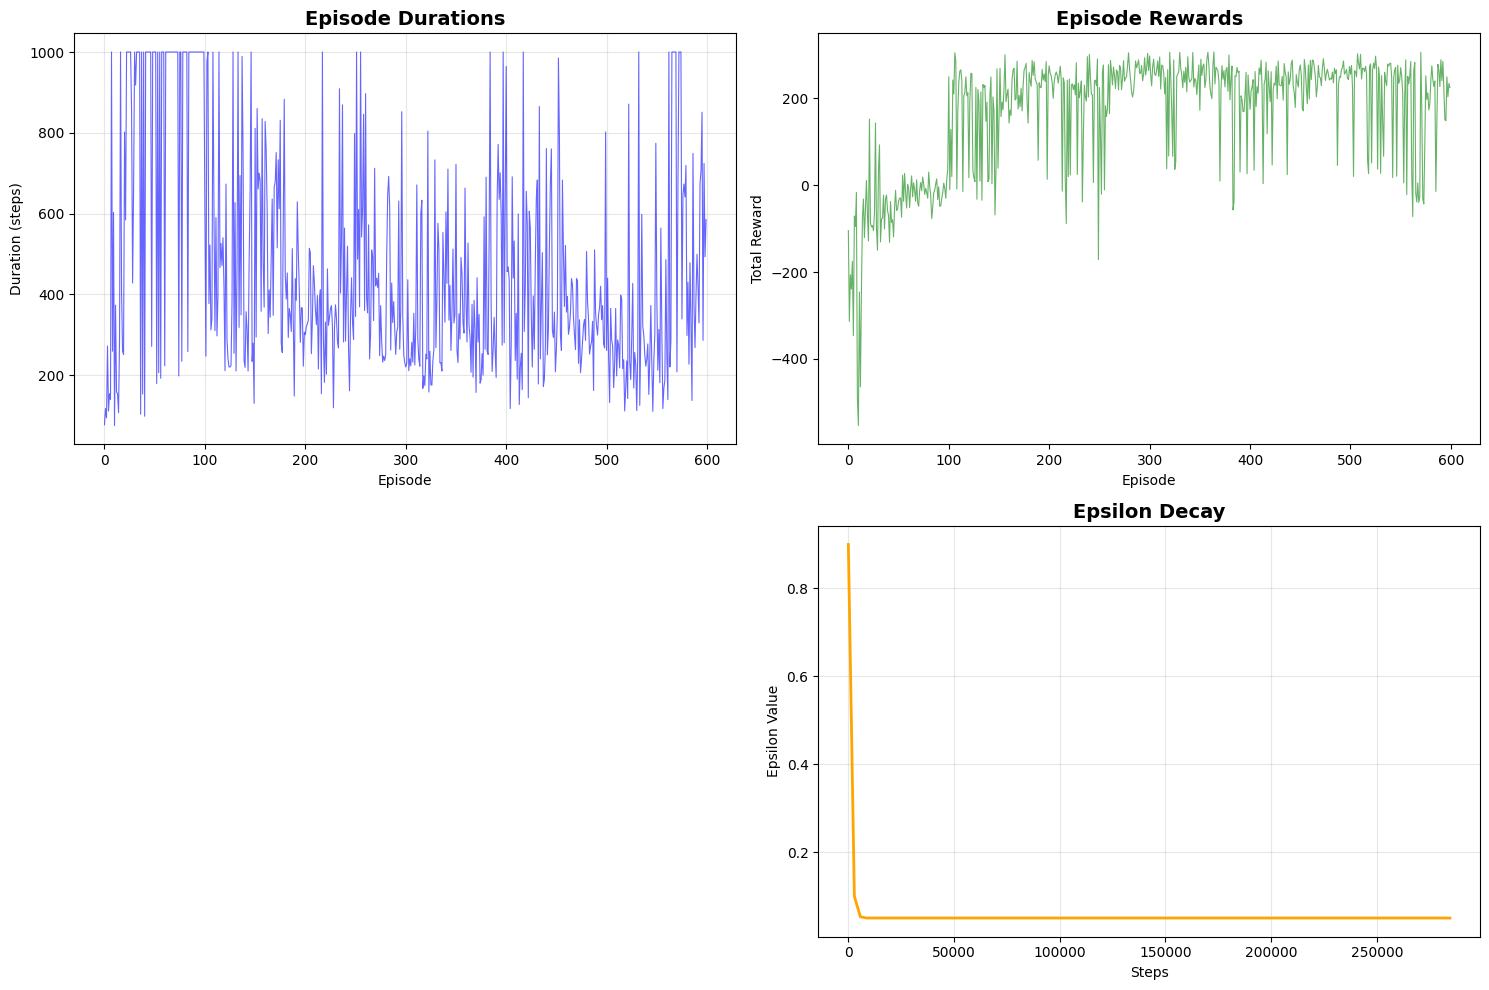

In [ ]:
# TODO: Create comprehensive training visualization

# TODO: Plot episode durations

# TODO: Plot episode rewards

# TODO: Plot epsilon decay

## 9️⃣ Agent Testing and Visualization

**Task**: Test the trained agent and create a video visualization.

**Requirements**:
- Test the trained agent without exploration (greedy policy)
- Record the agent's performance in the environment
- Create a video of the agent playing

In [ ]:
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

# Set up environment for video recording
os.environ['SDL_VIDEODRIVER']='dummy'

def show_video():
    """Display recorded video in Jupyter notebook."""
    mp4list = glob.glob('video*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="Trained DQN Agent" autoplay 
                loop controls style=\"height: 400px;\">
                <source src=\"data:video/mp4;base64,{0}\" type=\"video/mp4\" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

def wrap_env(env):
    """Wrap environment for video recording."""
    env = video_recorder.VideoRecorder(env, "video.mp4")
    return env

# Create test environment with rendering
env_test = gym.make("LunarLander-v2", render_mode="rgb_array")
vid = wrap_env(env_test)

# TODO: Run test episode

# TODO: Record frame for video

# TODO: Use trained policy network (no exploration - greedy policy)

# TODO: Execute action

# TODO: Check if episode finished

# TODO: Update state

vid.close()
env_test.close()

Testing Trained DQN Agent...


/home/ali/.virtualenvs/PythonProject/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode finished after 441 timesteps
Total reward: 251.11
🎉 SUCCESS: Agent achieved landing score ≥ 200!
MoviePy - Building video video.mp4.
MoviePy - Writing video video.mp4



MoviePy - Done !
MoviePy - video ready video.mp4


In [ ]:
show_video()

## 1️⃣0️⃣ Action Selection Pattern Analysis

**Task**: Analyze the agent's action selection patterns and preferences.

**Requirements**:
- Track action frequencies during test episodes
- Visualize action distribution patterns

Analyzing Action Selection Patterns...


/home/ali/.virtualenvs/PythonProject/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


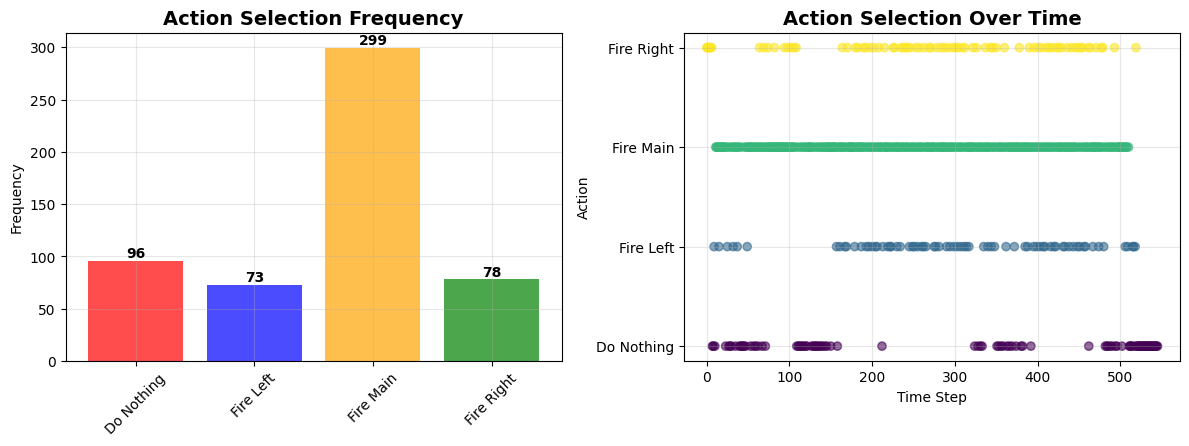

In [ ]:
# TODO: Analyze action selection patterns
print("Analyzing Action Selection Patterns...")
print("="*45)

action_names = ['Do Nothing', 'Fire Left', 'Fire Main', 'Fire Right']
action_counts = {name: 0 for name in action_names}
state_action_history = []

# TODO: Run episode and track all actions


# TODO: Get Q-values and select action


# TODO: Track action and state


# TODO: Execute action


# TODO: Visualize action distribution


# TODO: Plot action selection over time

## 📋 Assignment Evaluation Criteria

Your DQN homework will be evaluated based on the following criteria:

### **Implementation Correctness (40%)**
- ✅ Proper Double DQN algorithm implementation
- ✅ Correct experience replay mechanism
- ✅ Appropriate network architecture and training loop
- ✅ Proper epsilon-greedy exploration strategy
- ✅ Target network updates and soft copying

### **Training Performance (25%)**
- ✅ Agent trains without errors for specified episodes
- ✅ Achieves reasonable performance (average reward > 100) - After Training
- ✅ Shows clear learning progress over time
- ✅ Proper use of hyperparameters

### **Code Quality and Documentation (20%)**
- ✅ Clean, readable code with comprehensive comments
- ✅ Proper tensor handling and device management
- ✅ Efficient implementation without memory leaks
- ✅ Well-structured functions and classes

### **Analysis and Understanding (15%)**
- ✅ Comprehensive training visualizations
